# Exploratory data analysis of the Berlin dataset

Dataset can be found on https://www.kaggle.com/datasets/mathisjander/real-estate-listings-berlin-de-april-2023.

In [7]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [8]:
# Colorblind-friendly colors
colors = sns.color_palette("colorblind", 10)
sns.set_palette("colorblind")

### Data loading and quick exploration

In [9]:
data = pd.read_csv('../data/berlin_houses_apr2023.csv')

# Show first rows
data.head()

,url,energy,heating,price,area,rooms,fee,zipcode,construction_year,level,price_per_area
0,https://www.immowelt.de/expose/29fhx5b,Öl,Zentralheizung,249000.0,64.00,3.0,3.57,13505.0,1971.0,2.0,3890.625000
1,https://www.immowelt.de/expose/29hzk5u,Gas,"Fußbodenheizung, offener",1295000.0,136.06,4.0,3.57,10405.0,1900.0,5.0,9517.859768
2,https://www.immowelt.de/expose/292m95u,Gas,Etagenheizung,770000.0,120.00,4.0,3.57,12161.0,1900.0,5.0,6416.666667
3,https://www.immowelt.de/expose/29sh55u,Gas,Zentralheizung,349000.0,158.00,5.0,3.57,12103.0,1956.0,1.0,2208.860759
4,https://www.immowelt.de/expose/29r5y5t,Gas,Etagenheizung,494990.0,126.00,4.0,3.57,12157.0,1909.0,3.0,3928.492063


In [10]:
# Display key properties
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4942 entries, 0 to 4941
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   url                4942 non-null   object 
 1   energy             4942 non-null   object 
 2   heating            4942 non-null   object 
 3   price              4942 non-null   float64
 4   area               4942 non-null   float64
 5   rooms              4942 non-null   float64
 6   fee                4942 non-null   float64
 7   zipcode            4942 non-null   float64
 8   construction_year  4942 non-null   float64
 9   level              4942 non-null   float64
 10  price_per_area     4942 non-null   float64
dtypes: float64(8), object(3)
memory usage: 424.8+ KB


In [11]:
# Inspect types of 'object' columns
print(f" Type of 'url' variable : {type(data['url'][0])}\n", 
      f"Type of 'energy' variable : {type(data['energy'][0])}\n", 
      f"Type of 'heating' variable : {type(data['heating'][0])}")

 Type of 'url' variable : <class 'str'>
 Type of 'energy' variable : <class 'str'>
 Type of 'heating' variable : <class 'str'>


From the above and the description of the dataset on Kaggle, we have :
* *url* (string) : link to the announcement
* *energy* (string) : energy source type
* *heating* (string) : heating type
* *price* (float) : price of the house/flat
* *area* (float) : area in square meters
* *rooms* (float) : number of rooms
* *fee* (float) : agent fee
* *zipcode* (float) : ZIP code in Berlin
* *construction_year* (float) : year of construction
* *level* (float) : floor level
* *price_per_area* (float) : price per square meter

In [12]:
# Check unique values for each feature
print(f'Number of different values (on {len(data)} samples): \n\n{data.nunique()}')

Number of different values (on 4942 samples): 

url                  4942
energy                 20
heating                23
price                1430
area                 2119
rooms                  21
fee                    68
zipcode               190
construction_year     155
level                  20
price_per_area       3603
dtype: int64


In [13]:
# Check missing entries
print(f'Number of missing values : \n\n{data.isnull().sum()}')

Number of missing values : 

url                  0
energy               0
heating              0
price                0
area                 0
rooms                0
fee                  0
zipcode              0
construction_year    0
level                0
price_per_area       0
dtype: int64


In [14]:
# Check duplicates
print(f'Number of duplicated rows : {data.duplicated().sum()}')

Number of duplicated rows : 0


In [15]:
data.describe()

,price,area,rooms,fee,zipcode,construction_year,level,price_per_area
count,4.942000e+03,4942.000000,4942.000000,4942.000000,4942.000000,4942.000000,4942.000000,4942.000000
mean,5.654009e+05,85.067321,2.805544,5.891574,11954.461554,1944.344193,3.401255,6401.269284
std,6.107572e+05,58.315922,1.582906,121.004862,1628.058346,143.609751,29.137154,3183.956274
min,3.495000e+04,13.000000,1.000000,-3.500000,1099.000000,1.000000,1.000000,956.521739
25%,2.590000e+05,54.070000,2.000000,3.570000,10589.000000,1910.000000,1.000000,4537.537879
50%,3.899000e+05,72.740000,3.000000,3.570000,12161.000000,1956.000000,1.000000,5843.852267
75%,6.690000e+05,101.000000,3.000000,3.570000,13088.000000,1994.000000,3.000000,8063.468346
max,1.590000e+07,970.000000,26.000000,7996.000000,77933.000000,2026.000000,2023.000000,87739.070663


#### Summary : 
* **4942 different samples** in total
* **11 features** with different types : strings and floats
* **0 missing entries**
* Maybe some **outliers** (from the table above : 956.5 €/m² seems pretty low)

### Data cleaning

First, we ensure that zipcodes are in the right range. Indeed, they will be very useful in order to group properties by location and establish neighborhoods, so we need them to be clean.

With a quick web search, you can find that they are supposed to begin with '10', '12', '13' or '14' in Berlin. We will thus perform some simple string manipulation to filter out the examples that doesn't match this condition :

In [16]:
data = data[data['zipcode'].astype(str).str.startswith(('10', '12', '13', '14'))]
print(f'Number of different zipcodes : {len(data['zipcode'].unique())}')

Number of different zipcodes : 188


We get something very close to the real total number (194).

Then, we look for potentially unnecessary attributes. 

We can start by filtering out the *url* column which we will definitely never use. 

In [17]:
data.drop(columns='url', inplace=True)

Our main focus in this project is on property values and neighborhoods patterns in the cities, so we already know that price, size-related and geographical features could be useful. For the other ones, we can do a simple correlation analysis to assess their relevance :

In [18]:
features_to_check = ['energy', 'heating', 'fee', 'construction_year', 'level']
encoded_features = pd.get_dummies(data[features_to_check]) # some attributes are categorical so we need to hot-encode them

# Check correlation with the 'price' feature
print(f'Correlation with price : \n\n{encoded_features.corrwith(data['price'])}')

Correlation with price : 

fee                                 -0.005078
construction_year                   -0.040873
level                                0.010718
energy_Blockheizkraftwerk           -0.008796
energy_Blockheizkraftwerk,           0.041180
energy_Elektro                      -0.004102
energy_Elektro,                      0.019231
energy_Erdwärme                     -0.004496
energy_Erdwärme,                    -0.009469
energy_Fernwärme                     0.094477
energy_Fernwärme,                    0.002723
energy_Flüssiggas                   -0.010823
energy_Fußbodenheizung,              0.019732
energy_Fußbodenheizung, offener      0.025265
energy_Gas                          -0.026456
energy_Gas,                          0.012487
energy_Holz,                        -0.006208
energy_Luft-/                        0.033329
energy_Niedrigenergiehaus           -0.002737
energy_Pellets                       0.027748
energy_Solar                         0.029445
energy_

We observe very poor correlation between *price* and *fee*, *construction_year*, *level*, *energy*, *heating* features, which suggest that they are likely not very meaningful for our work. 

Even though correlation may fail to capture non-linear types of relationships, we will just drop these attributes because they will not be insightful for the visualizations we will made with the data :

In [19]:
data.drop(columns=features_to_check, inplace=True)

Finally, we address the problem of outliers by checking price values very far from the mean in our dataset :

In [20]:
high_price_outliers = data[data["price"] > data["price"].quantile(0.99)]
high_price_outliers.describe()

,price,area,rooms,zipcode,price_per_area
count,5.000000e+01,50.000000,50.000000,50.000000,50.000000
mean,4.511858e+06,292.252400,6.060000,10816.840000,18960.078077
std,2.263474e+06,144.162699,3.079955,972.706877,17925.615459
min,2.864800e+06,72.740000,3.000000,10115.000000,6701.030928
25%,3.006712e+06,222.000000,4.000000,10179.000000,12389.800315
50%,3.750000e+06,254.885000,5.000000,10707.000000,14479.294358
75%,5.087500e+06,302.540000,8.000000,10784.500000,16649.018421
max,1.590000e+07,970.000000,22.000000,14193.000000,87739.070663


In [21]:
low_price_outliers = data[data["price"] < data["price"].quantile(0.01)]
low_price_outliers.describe()

,price,area,rooms,zipcode,price_per_area
count,50.000000,50.000000,50.000000,50.000000,50.000000
mean,110009.520000,36.310400,1.300000,12489.940000,3374.045534
std,16850.211811,16.139787,0.614452,1194.539283,1035.072376
min,34950.000000,13.000000,1.000000,10115.000000,956.521739
25%,99237.500000,28.932500,1.000000,12099.000000,2737.898596
50%,110271.500000,33.905000,1.000000,12865.000000,3428.046561
75%,120000.000000,40.000000,1.000000,13509.000000,3807.261113
max,131600.000000,115.000000,3.000000,14169.000000,5686.387134


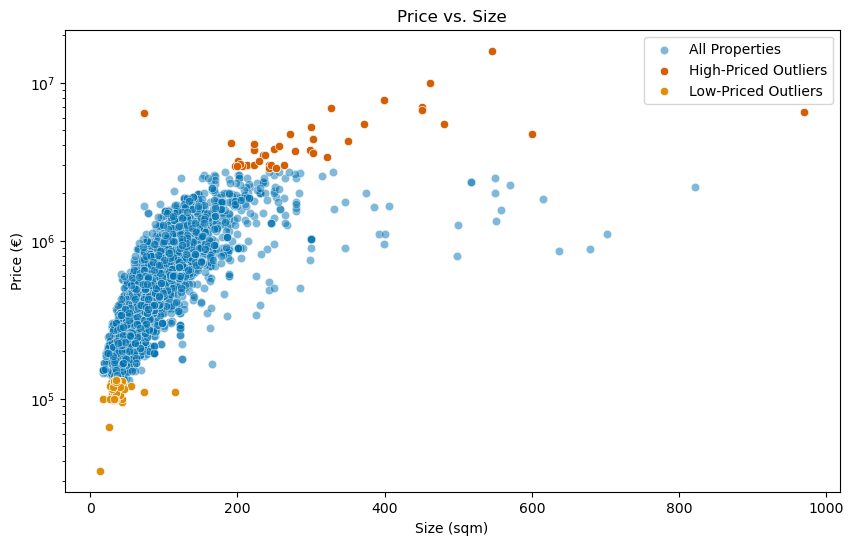

In [22]:
# Visualize outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['area'], y=data['price'], alpha=0.5, label='All Properties')
sns.scatterplot(x=high_price_outliers['area'], y=high_price_outliers['price'], color=colors[3], label='High-Priced Outliers')
sns.scatterplot(x=low_price_outliers['area'], y=low_price_outliers['price'], color=colors[1], label='Low-Priced Outliers')
plt.xlabel('Size (sqm)')
plt.ylabel('Price (€)')
plt.yscale('log')
plt.title('Price vs. Size')
plt.legend()
plt.show()

For the moment, we can get rid of the high-priced example where size < 100m² as it is clearly out of the distribution. But for the other outliers, it is difficult to say if they are credible exceptions (e.g. luxury houses, studio apartments) or erroneous data points, as they kind of follow the tendance. We will probably explore this more in depth for next time.

In [23]:
data = data.drop(high_price_outliers[high_price_outliers['area'] < 100].index)

### Visualizations

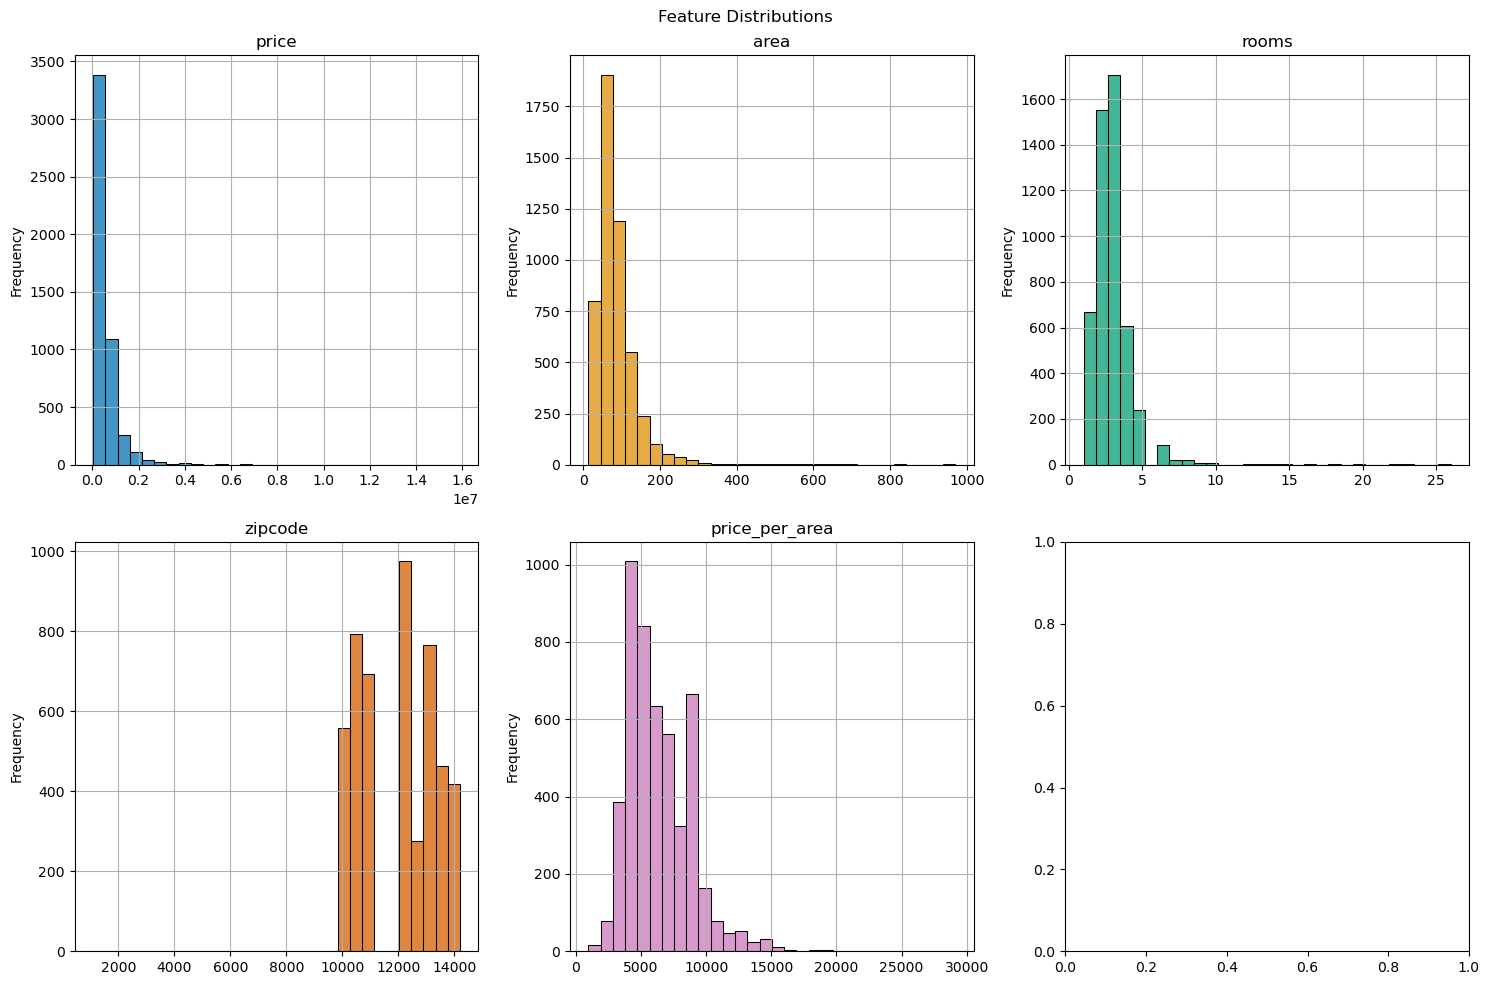

In [24]:
# Feature distributions

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(data.columns):
    sns.histplot(data[feature], ax=axes[i], color=colors[i], bins=30)
    axes[i].set_ylabel("Frequency")
    axes[i].set_title(feature)
    axes[i].set_xlabel("")
    axes[i].grid(True)


# Add legend and title
fig.suptitle("Feature Distributions")
plt.tight_layout()
plt.show()

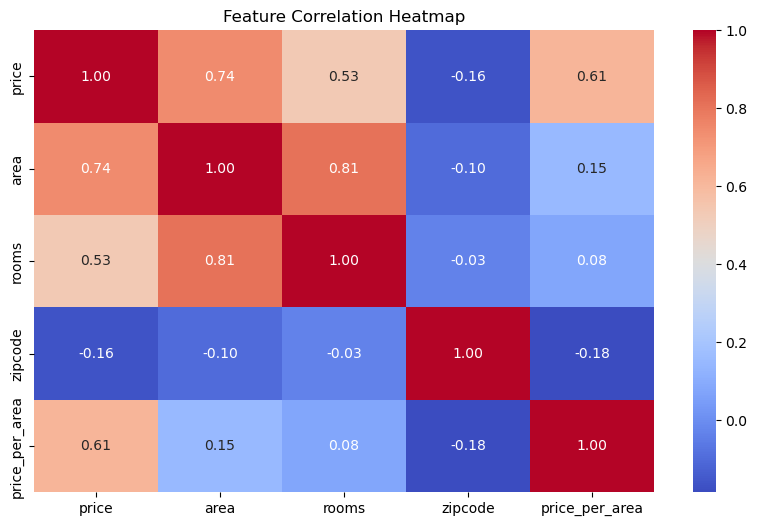

In [25]:
# Heatmap for numeric and binary features
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title(f'Feature Correlation Heatmap')
plt.show()

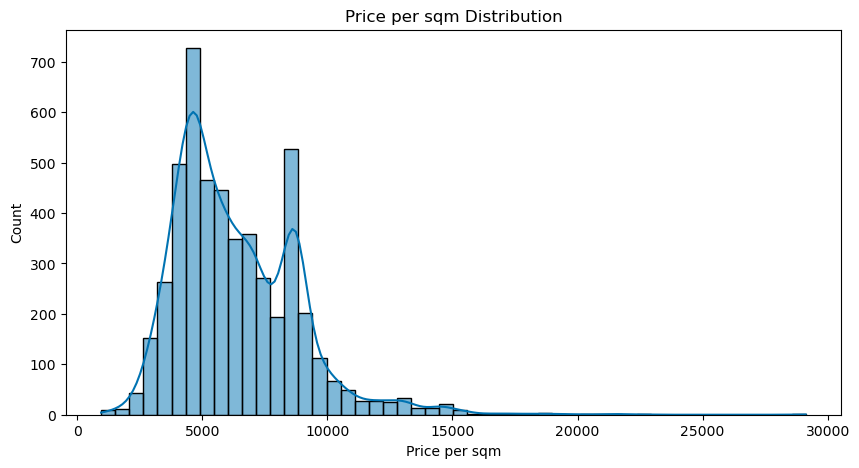

In [26]:
plt.figure(figsize=(10, 5))
sns.histplot(data['price_per_area'], bins=50, kde=True)
plt.title(f'Price per sqm Distribution')
plt.xlabel('Price per sqm')
plt.ylabel('Count')
plt.show()
plt.show()

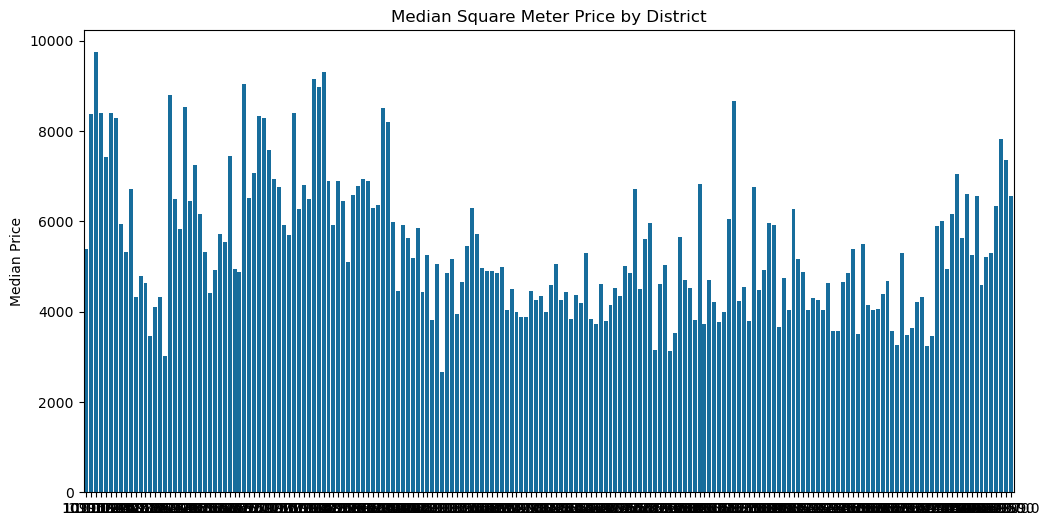

In [28]:
plt.figure(figsize=(12, 6))
sns.barplot(x=data.groupby('zipcode')['price_per_area'].median().index, y=data.groupby('zipcode')['price_per_area'].median().values)
plt.title(f'Median Square Meter Price by District')
plt.xlabel("")
plt.ylabel('Median Price')
plt.show()

# Visualisations for site 


### Scatter plot 

Scatter plot of various of features mainlu focusing on price evolution depending other features.

In [48]:
df = pd.read_csv('../data/berlin_houses_apr2023.csv')

#get how many unique zipcode is in the dataset
unique_zipcodes = df['zipcode'].nunique()
print(f'Number of unique zipcodes: {unique_zipcodes}')

#keep only the zipcodes that start with 10, 12, 13, 14
df = df[df['zipcode'].astype(str).str.startswith(('10', '12', '13', '14'))]
print(f'Number of unique zipcodes after filtering: {df['zipcode'].nunique()}')

df = df.drop(columns='url')

df

Number of unique zipcodes: 190
Number of unique zipcodes after filtering: 188


,energy,heating,price,area,rooms,fee,zipcode,construction_year,level,price_per_area
0,Öl,Zentralheizung,249000.0,64.00,3.0,3.57,13505.0,1971.0,2.0,3890.625000
1,Gas,"Fußbodenheizung, offener",1295000.0,136.06,4.0,3.57,10405.0,1900.0,5.0,9517.859768
2,Gas,Etagenheizung,770000.0,120.00,4.0,3.57,12161.0,1900.0,5.0,6416.666667
3,Gas,Zentralheizung,349000.0,158.00,5.0,3.57,12103.0,1956.0,1.0,2208.860759
4,Gas,Etagenheizung,494990.0,126.00,4.0,3.57,12157.0,1909.0,3.0,3928.492063
...,...,...,...,...,...,...,...,...,...,...
4937,Fernwärme,"Fußbodenheizung,",429000.0,78.00,3.0,3.57,13595.0,2000.0,1.0,5500.000000
4938,Gas,Zentralheizung,729000.0,150.00,4.0,3.57,13467.0,1990.0,1.0,4860.000000
4939,Gas,Etagenheizung,695600.0,94.00,3.0,3.57,10115.0,1900.0,1.0,7400.000000
4940,Fernwärme,Minergie zertifiziert,839251.0,107.00,3.0,3.57,13591.0,1894.0,1.0,7843.467290


In [53]:
df['zipcode'].value_counts().head(10)

zipcode
13088.0    477
10247.0    128
10245.0    114
12157.0     84
10717.0     83
10439.0     82
10243.0     81
14193.0     75
13156.0     73
13187.0     63
Name: count, dtype: int64

In [74]:
# plot in plotly price vs area per zipcode (vategorical)

import plotly.express as px
fig = px.scatter(df, x='area', y='price', title='Price vs Area per Zipcode' )
fig.update_traces(marker=dict(size=5), marker_color='pink')
fig.update_layout(title='Price vs Area per Zipcode', xaxis_title='Area', yaxis_title='Price', width=800, height=600)
# transparent background
fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', font_color = "white" )
fig.show()

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

# Medium-priced properties (€300k to €2M)
medium = df[(df['price'] <= 2_000_000) & (df['price'] >= 300_000)]
fig = px.scatter(
    medium,
    x='area',
    y='price',
    title='Price vs Area per Zipcode',
)

fig.update_traces(marker=dict(size=5, color='#D8C6B3'), name='€300k–€2M')

# High-price properties > €2M
high_price = df[df['price'] > 2_000_000]
fig.add_trace(go.Scatter(
    x=high_price['area'],
    y=high_price['price'],
    mode='markers',
    marker=dict(size=6, color='#CC673D'),
    name='> €2M'
))

# Low-price properties < €300k
low_price = df[df['price'] < 300_000]
fig.add_trace(go.Scatter(
    x=low_price['area'],
    y=low_price['price'],
    mode='markers',
    marker=dict(size=6, color='#585424'),
    name='< €300k'
))

# Layout
fig.update_layout(
    width=1200,
    height=600,
    xaxis_title='Area (m²)',
    yaxis_title='Price (€)',
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    font_color="white"
)
fig.update_yaxes(type="log")

fig.show()

In [111]:
df['construction_year'].sort_values(ascending=True).head(10)

1975    1.0
1977    1.0
2517    1.0
4615    1.0
1976    1.0
1760    1.0
1974    1.0
1973    1.0
1978    1.0
1953    1.0
Name: construction_year, dtype: float64

In [142]:
import plotly.express as px

fig = px.scatter(df, x='construction_year', y='price', title='Price vs Year of Construction')

fig.update_traces(marker=dict(size=5, color='#D8C6B3'), name='Price vs Year of Construction')
fig.update_layout(
    title='Price vs Year of Construction',
    xaxis_title='Year of Construction',
    yaxis_title='Price',
    width=1300,
    height=600,
    #set grey background
    plot_bgcolor='rgba(100,100,100,50)',
    paper_bgcolor='rgba(0,0,0,0)',
    font_color="white", 

)

# Fix: set X (not Y) axis range from 1975 to 2026
fig.update_xaxes(range=[1975, 2026])
#lim of y axis at 12 M 
fig.update_yaxes(range=[0, 12_000_000])

fig.show()

In [141]:
# scatter for price vs number of rooms categorical 
fig = px.scatter(df, x='rooms', y='price', title='Price vs Number of Rooms')
fig.update_traces(marker=dict(size=5, color='lightblue'), name='Price vs Number of Rooms')
fig.update_layout(
    title='Price vs Number of Rooms',
    xaxis_title='Number of Rooms',
    yaxis_title='Price',
    width=1600,
    height=600,
    #set grey background
    plot_bgcolor='rgba(100,100,100,50)',
    paper_bgcolor='rgba(0,0,0,0)',
    font_color="white", 
)

fig.show()
